In [30]:
import numpy as np
import os
from PIL import Image, features
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import torch
import tensorflow as tf
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from ae import AutoEncoder

from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/introduction')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using the device",device)

%reload_ext autoreload
%autoreload 2


Using the device cuda:0


In [4]:
from random import randint
def take_random_tile(img_raw,tile_size=8,sample_shape_range=None):
    channels, width,height=list(img_raw.shape) #(3,width,height)

    if sample_shape_range != None:
        min_size, max_size = sample_shape_range

        tile_size = randint(min_size,max_size)

        if tile_size > width or tile_size > height: #correct for sample sizes bigger than the image
            tile_size = min(height,width)
    
    top  = randint(0,width-tile_size)
    left = randint(0,height-tile_size)

    tile_tensor = img_raw[:,top:top+tile_size,left:left+tile_size] #tile
    #print(list(tile_tensor.shape))

    if sample_shape_range != None:
        tile_tensor = F.interpolate(tile_tensor,size=(channels,tile_size,tile_size))
    return tile_tensor
    


In [11]:
from random import sample
def get_tile_batch(image_list, batch_size=1000, tile_size=8, sample_shape_range=None):
    convert_tensor = transforms.ToTensor()
    while True:
        tile_list = [] #initialize batch tensor
        for i in range(batch_size):
            next_image,=sample(image_list,k=1)
            image_tensor = convert_tensor(Image.open(next_image).convert('RGB'))
            tile = take_random_tile(image_tensor,tile_size,sample_shape_range)
            #print(tile.shape)
            tile_list.append(tile)

        batch = torch.stack(tile_list)
        yield batch

In [6]:
from os import listdir
from os.path import isdir, join

wd_path = os.path.abspath(os.getcwd())
root_path = os.path.join(wd_path, "datasets", 'ImageNet','train')


image_path_list = []
for d in listdir(root_path):
    #d = n016...
    class_path = join(root_path,d,"images")
    for i in listdir(class_path):
        #i = n016..._n.JPEG
        image_path_list.append(join(class_path,i))

batch_maker = get_tile_batch(image_path_list,batch_size=10)


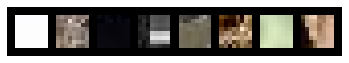

In [7]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

    plt.show()

# get some random training images
batch_maker = get_tile_batch(image_path_list,batch_size=8)
sample_images = next(batch_maker)

# show images
imshow(torchvision.utils.make_grid(sample_images))
# print labels

In [8]:
def train_autoencoder(epoch_size, train_loader,optimizer,model,criterion,max_epochs):
    training_loss_history= []
    loss = 0
    min_loss = 1
    for epoch_number,tiles in enumerate(train_loader):

        # reshape mini-batch data to [N, 3*8*8] matrix
        # load it to the active device
        tiles = tiles.to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        outputs = model(tiles)                 # compute reconstructions
        train_loss = criterion(outputs, tiles.view(-1, 3*8*8)) # compute training reconstruction loss
        train_loss.backward()                  # compute accumulated gradients
        optimizer.step()                       # perform parameter update based on current gradients
        loss += train_loss.item()              # add the mini-batch training loss to epoch loss
        
        if epoch_number%epoch_size == epoch_size-1:
            # compute the epoch training loss
            loss = loss / epoch_size
            if loss < min_loss:
                min_loss = loss
                best_params = model.state_dict()
            # display the epoch training loss
            print(f"epoch : {(epoch_number+1)/epoch_size}, loss = {loss:.6f}")
            training_loss_history.append(loss)
            loss = 0
            if(epoch_number >= max_epochs):
                return best_params
                
    return 

In [31]:
net = AutoEncoder()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
batch_maker = get_tile_batch(image_path_list,batch_size=1000)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [37]:
best_state_dict = train_autoencoder(10, batch_maker, optimizer, net, criterion,max_epochs=6600)
#net.load_state_dict(best_state_dict)

epoch : 1.0, loss = 0.011681
epoch : 2.0, loss = 0.011418
epoch : 3.0, loss = 0.011560
epoch : 4.0, loss = 0.011693
epoch : 5.0, loss = 0.011612
epoch : 6.0, loss = 0.011717
epoch : 7.0, loss = 0.011680
epoch : 8.0, loss = 0.011654
epoch : 9.0, loss = 0.011917
epoch : 10.0, loss = 0.011740
epoch : 11.0, loss = 0.011801
epoch : 12.0, loss = 0.011772
epoch : 13.0, loss = 0.011870
epoch : 14.0, loss = 0.011950
epoch : 15.0, loss = 0.011910
epoch : 16.0, loss = 0.011709
epoch : 17.0, loss = 0.011675
epoch : 18.0, loss = 0.011615
epoch : 19.0, loss = 0.011796
epoch : 20.0, loss = 0.011859
epoch : 21.0, loss = 0.011748
epoch : 22.0, loss = 0.011782
epoch : 23.0, loss = 0.011832
epoch : 24.0, loss = 0.011701
epoch : 25.0, loss = 0.011619
epoch : 26.0, loss = 0.011828
epoch : 27.0, loss = 0.011850
epoch : 28.0, loss = 0.011738
epoch : 29.0, loss = 0.011484
epoch : 30.0, loss = 0.011770
epoch : 31.0, loss = 0.011964
epoch : 32.0, loss = 0.011866
epoch : 33.0, loss = 0.011643
epoch : 34.0, loss 

In [38]:
models_path = os.path.join(wd_path, "models")

net.save_model(os.path.join(models_path, "ae_1.pt"))

In [ ]:
# get some random training images
batch_maker = get_tile_batch(image_path_list,batch_size=1)
images = next(batch_maker)

images = images.to(device)
x_r = net.encode(images[0].view(3*8*8))
x_rebuilt_r = net.decode(x_r).detach().cpu().view(3,8,8)

# show images
imshow(torchvision.utils.make_grid(x_rebuilt_r))
print("Original")
imshow(images[0].detach().cpu().view(3,8,8))
# print labels

In [19]:
models_path = os.path.join(wd_path, "models")
loaded_autoencoder = AutoEncoder.load_autoencoder(os.path.join(models_path, "ae_0.pt"))
loaded_autoencoder.to(device)


AutoEncoder(
  (activation): ReLU()
  (fc1): Linear(in_features=192, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=96, bias=True)
  (fc4): Linear(in_features=96, out_features=192, bias=True)
)

Original
Reconstructed


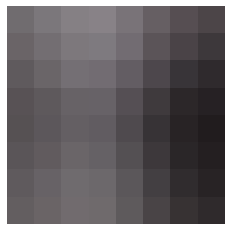

Original


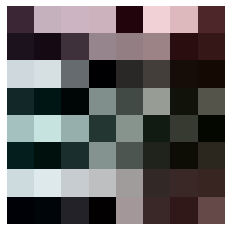

In [28]:
# get some random training images
batch_maker = get_tile_batch([os.path.join(wd_path, "images","val_0_0.jpeg")],batch_size=1)
images = next(batch_maker)
images = images.to(device)

print("Original")

x_r = loaded_autoencoder.encode(images.view(-1,3*8*8))
x_rebuilt_r = loaded_autoencoder.decode(x_r).detach().cpu().view(3,8,8)

print("Reconstructed")
# show images
imshow(x_rebuilt_r)
print("Original")

imshow(images[0].detach().cpu().view(3,8,8))
# print labels